In [11]:
import warnings
from glob import glob

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

# Data Wrangling

We are interested in predicting apartment prices in Buenos Aires (`"Capital Federal"`) that cost less than $400,000. First we will filter the data to extract what we need

We create a function to handle data wrangling since that data have the same structure. We can pass the file through the functino to process it faster

In [24]:
def wrangle(filepath):
    df = pd.read_csv(filepath)

    # Subset data: Apartment, Capital Federal, < $400,000
    mask_1 = df['property_type'] == 'apartment'
    mask_2 = df['place_with_parent_names'].str.contains('Capital Federal')
    mask_3 = df['price_aprox_usd'] < 400000

    df = df[mask_1 & mask_2 & mask_3]

    # Remove outliers in surface_covered_in_m2
    area_low, area_high = df['surface_covered_in_m2'].quantile([0.1, 0.9])
    mask_area = df['surface_covered_in_m2'].between(area_low, area_high)

    df = df[mask_area]
    return df

In [25]:
df = wrangle('data/buenos-aires-real-estate-1.csv')
df.head()

,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...
9,sell,apartment,|Argentina|Capital Federal|Villa Luro|,"-34.6389789,-58.500115",87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...
29,sell,apartment,|Argentina|Capital Federal|Caballito|,"-34.615847,-58.459957",118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...
40,sell,apartment,|Argentina|Capital Federal|Constitución|,"-34.6252219,-58.3823825",57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364,http://constitucion.properati.com.ar/k2f0_vent...
41,sell,apartment,|Argentina|Capital Federal|Once|,"-34.6106102,-58.4125107",90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450,http://once.properati.com.ar/suwa_venta_depart...


In [23]:
# Before
df.describe()

,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms
count,1.781000e+03,1.781000e+03,1781.000000,1247.000000,1635.000000,1198.000000,1618.000000,482.000000,1385.000000
mean,2.285410e+05,2.178037e+06,143647.215239,114.417001,97.877064,2231.534726,4340.345113,10.085062,2.434657
std,4.100189e+05,1.141710e+06,75298.758506,1755.263895,1533.057610,650.139587,8126.940810,44.783320,1.065193
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2.224587,1.000000,1.000000
25%,9.000000e+04,1.349454e+06,89000.000000,40.000000,38.000000,1815.485830,1973.750000,2.000000,2.000000
50%,1.300000e+05,1.849813e+06,122000.000000,55.000000,50.000000,2151.642336,2411.239496,4.000000,2.000000
75%,1.911340e+05,2.653420e+06,175000.000000,79.000000,73.000000,2577.003583,2958.157462,7.000000,3.000000
max,5.487000e+06,6.034635e+06,398000.000000,62034.000000,62034.000000,5975.609756,57156.250000,616.000000,6.000000


It looks like `surface_covered_in_m2` contains outlier. Looking at the statistic, while most of the apartments in our dataset are smaller that 73 square meters, there are some that are several thousand square meters. We will modify our `wrangle` function to remove the outliers

In [26]:
# After
df.describe()

,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms
count,1.343000e+03,1.343000e+03,1343.000000,965.000000,1343.000000,927.000000,1343.000000,379.000000,1078.000000
mean,2.204582e+05,2.054927e+06,135527.838719,59.883938,55.076694,2244.163063,4285.479770,11.155673,2.364564
std,4.151182e+05,9.033095e+05,59575.630208,26.621969,18.160427,639.740608,7987.685558,50.138692,0.902759
min,2.727900e+04,4.136151e+05,27279.000000,0.000000,31.000000,513.513514,808.148936,1.000000,1.000000
25%,9.325000e+04,1.394941e+06,92000.000000,42.000000,40.000000,1826.505017,1975.872093,2.000000,2.000000
50%,1.259000e+05,1.819935e+06,120029.460000,55.000000,50.000000,2141.519231,2411.764706,4.000000,2.000000
75%,1.750000e+05,2.425984e+06,160000.000000,75.000000,68.500000,2578.183144,2964.814815,7.000000,3.000000
max,5.487000e+06,5.989148e+06,395000.000000,229.000000,100.000000,5777.777778,57156.250000,616.000000,6.000000


(array([246., 240., 223., 136., 130., 107.,  84.,  79.,  47.,  51.]),
 array([ 31. ,  37.9,  44.8,  51.7,  58.6,  65.5,  72.4,  79.3,  86.2,
         93.1, 100. ]),
 <BarContainer object of 10 artists>)

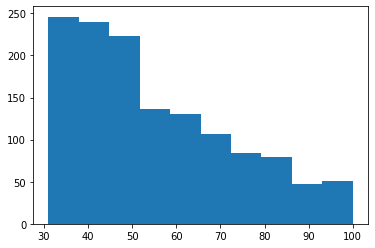

In [27]:
plt.hist(df['surface_covered_in_m2'])